In [1]:
# %pip install opencv-python-headless

In [27]:
import os
import cv2
import numpy as np
from scipy.ndimage import gaussian_filter
import random
from typing import Union, Tuple, List
from scipy.stats import norm
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import skewnorm


# def generate_skewed_blob(image_size, center, sigma, alpha=(-2.5,2.5), normalization=True):
#     """
#     Create a fully asymmetric (skewed) Gaussian-like blob and
#     return it along with the selected sigmas.

#     :param image_size: Tuple[int, int] (height, width) of the output image
#     :param center: Tuple[int, int] (x, y) pixel coordinates of the blob center
#     :param sigma_x_range: Tuple[float, float] range from which to pick σx
#     :param sigma_y_range: Tuple[float, float] range from which to pick σy
#     :param alpha_x_range: Tuple[float, float] range from which to pick αx (skew on x)
#     :param alpha_y_range: Tuple[float, float] range from which to pick αy (skew on y)
#     :return:
#         blob: np.ndarray of shape (height, width), values in [0,1]
#         sigma: Tuple[float, float] = (σx, σy)
#     """
#     h, w = image_size
#     cx, cy = center

#     # pick random scales and skews
#     sigma_x = random.uniform(*sigma)*1.05
#     sigma_y = random.uniform(*sigma)
#     alpha_x = random.uniform(*alpha)
#     alpha_y = random.uniform(*alpha)*0.95

#     # build coordinate grid relative to center
#     xs = np.arange(w) - cx
#     ys = np.arange(h) - cy
#     xv, yv = np.meshgrid(xs, ys)

#     # normalize by chosen sigmas
#     nx = xv / sigma_x
#     ny = yv / sigma_y

#     # skew-normal marginals
#     fx = skewnorm.pdf(nx, a=alpha_x)
#     fy = skewnorm.pdf(ny, a=alpha_y)

#     # joint asymmetric blob
#     canvas = fx * fy

#     # normalize to [0,1]
#     if canvas.max() > 0 and normalization:
#         canvas /= canvas.max()

#     canvas *= norm.pdf(random.gauss(mu=0.0, sigma=1.0), loc=0, scale=1)*np.sqrt(2*np.pi)

#     # return in the same style as the original function
#     sigma = (sigma_x, sigma_y)

#     return canvas, sigma


def generate_skewed_blob(image_size, center, sigma_range, alpha=(-2.5,2.5), normalization=True):
    h, w = image_size
    cx, cy = center

    # sample parameters (keep as in your original function or make explicit)
    sigma_x = random.uniform(*sigma_range) * 1.05
    sigma_y = random.uniform(*sigma_range)
    alpha_x = random.uniform(*alpha)
    alpha_y = random.uniform(*alpha) * 0.95

    xs = np.arange(w) - cx
    ys = np.arange(h) - cy
    xv, yv = np.meshgrid(xs, ys)

    nx = xv / sigma_x
    ny = yv / sigma_y

    fx = skewnorm.pdf(nx, a=alpha_x)
    fy = skewnorm.pdf(ny, a=alpha_y)

    canvas = fx * fy
    if canvas.max() > 0 and normalization:
        canvas /= canvas.max()

    # compute centroid in pixel coordinates (weighted by canvas)
    total = canvas.sum()
    if total > 0:
        ys_idx = np.arange(h)[:, None]
        xs_idx = np.arange(w)[None, :]
        cx_blob = (canvas * xs_idx).sum() / total
        cy_blob = (canvas * ys_idx).sum() / total
        # current centroid coordinates are relative to absolute image indices, but because
        # we built xs,ys relative to cx,cy, the centroid is already in absolute pixel coords:
        # cx_blob, cy_blob are absolute x and y indices
    else:
        cx_blob, cy_blob = cx, cy

    # compute shift needed to move centroid to requested center
    shift_x = int(round(cx - cx_blob))
    shift_y = int(round(cy - cy_blob))

    # shift the canvas back so its centroid is at (cx, cy)
    canvas_shifted = np.zeros_like(canvas)
    # use roll then zero out wrapped parts for simplicity
    canvas_shifted = np.roll(canvas, shift=(shift_y, shift_x), axis=(0, 1))
    # zero-out wrapped stripes introduced by roll
    if shift_y > 0:
        canvas_shifted[:shift_y, :] = 0
    elif shift_y < 0:
        canvas_shifted[shift_y:, :] = 0
    if shift_x > 0:
        canvas_shifted[:, :shift_x] = 0
    elif shift_x < 0:
        canvas_shifted[:, shift_x:] = 0

    return canvas_shifted, (sigma_x, sigma_y)


def generate_gaussian_blob(image_size, center, sigma, normalization=True):
    """
    Create a single-channel Gaussian blob on an empty canvas.

    :param image_size: Tuple[int, int] (height, width) of the output image.
    :param center: Tuple[int, int] (x, y) pixel coordinates of the blob center.
    :param sigma: Float, standard deviation of the Gaussian.
    :return: np.ndarray of shape (height, width), values normalized to [0,1].
    """
    h, w = image_size
    canvas = np.zeros((h, w), dtype=np.float32)
    x, y = center

    if 0 <= x < w and 0 <= y < h:
        canvas[y, x] = 1

    sigma = random.randint(*sigma)
    canvas = gaussian_filter(canvas, sigma=sigma)
    
    if canvas.max() > 0 and normalization:
        canvas /= canvas.max()

    canvas *= norm.pdf(random.gauss(mu=0.0, sigma=1.0), loc=0, scale=1)*np.sqrt(2*np.pi)

    sigma = (sigma, sigma)

    return canvas, sigma


def generate_heatmap_and_boxes(image_size, num_blobs, sigma_range, offset_range, box_sizes):
    """
    Generate a heatmap with up to num_blobs Gaussian blobs clustered together,
    and compute each blob’s bounding box.

    :param image_size: Tuple[int, int] (height, width) of the image.
    :param num_blobs: Int, how many Gaussians to place (1 to 3).
    :param sigma_range: Float, Gaussian blur sigma for each blob.
    :param offset_range: Tuple[int, int], min and max pixel offset from the cluster center.
    :return:
        heatmap: np.ndarray of shape (h, w) with values in [0,1],
        boxes: List[Tuple[int, int, int, int]] as (x_min, y_min, x_max, y_max).
    """
    h, w = image_size

    if len(box_sizes) > 2:
       raise ValueError("Invalid input: len(box_sizes) must be at least 2.")

    margin = int(2*min(offset_range) + 5*max(sigma_range))
    cx = random.randint(margin, w - margin - 1)
    cy = random.randint(margin, h - margin - 1)

    centers = []
    for _ in range(0, num_blobs):
        angle = random.uniform(0, 2 * np.pi)
        dist = random.randint(offset_range[0], offset_range[1])
        # dx = int(dist * np.cos(angle))
        dx = float('inf')
        while cx + dx < 0 or cx + dx > h:
            dx = int(dist * np.cos(angle))

        dy = 0#int(dist * np.sin(angle))
        centers.append((cx + dx, cy + dy))

    heatmap = np.zeros((h, w), dtype=np.float32)
    boxes = []
    for x, y in centers:
        blob, sigma = generate_skewed_blob(image_size, (x, y), sigma_range)
        # blob, sigma = generate_gaussian_blob(image_size, (x, y), sigma)
        heatmap = np.maximum(heatmap, blob)

        xs = []
        for s in box_sizes:
            x_size = int(3*sigma[0] * s)  # roughly ±3σ
            y_size = int(3*sigma[1] * s)  # roughly ±3σ

            x_min = max(0, x - x_size // 2)
            y_min = max(0, y - y_size // 2)
            x_max = min(w - 1, x + x_size // 2)
            y_max = min(h - 1, y + y_size // 2)

            xs.append([x_min, y_min, x_max, y_max])
            
        boxes.append(tuple([x for xi in xs for x in xi]))

    return heatmap, boxes


def generate_dataset(num_images, image_size, sigma_range, offset_range, output_dir):
    """
    Create a dataset of synthetic **colored** heatmap images and box annotations.

    :param num_images: Int, total images to generate.
    :param image_size: Tuple[int, int], (height, width) of each image.
    :param sigma: Float, Gaussian blur sigma for blobs.
    :param offset_range: Tuple[int, int], min/max blob‐cluster offset.
    :param output_dir: Path where `images/` and `labels/` folders will be created.
    :return: None
    """
    img_dir = os.path.join(output_dir, 'images')
    lbl_dir = os.path.join(output_dir, 'labels')
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(lbl_dir, exist_ok=True)

    for idx in range(num_images):
        n_blobs = random.randint(1, MAX_BLOBS)
        heatmap, boxes = generate_heatmap_and_boxes(image_size, n_blobs, sigma_range, offset_range, box_sizes=BOX_SIZES)

        # ONE-BOX for all dist
        # boxes = np.array(boxes)
        # boxes = [tuple([boxes[:,0].min(), boxes[:,1].min(), boxes[:,2].max(), boxes[:,3].max(), boxes[:,4].min(), boxes[:,5].min(), boxes[:,6].max(), boxes[:,7].max()])]
        # END ONE-BOX for all dist
        
        # 1) Convert to 8-bit grayscale
        gray = (heatmap * 255).astype(np.uint8)

        # 2) Apply JET colormap → BGR color image
        colored = cv2.applyColorMap(gray, cv2.COLORMAP_JET)

        # 3) Save the colored heatmap
        img_path = os.path.join(img_dir, f'img_{idx:05d}.jpg')
        cv2.imwrite(img_path, colored)

        # 4) Save box coordinates
        lbl_path = os.path.join(lbl_dir, f'img_{idx:05d}.txt')
        with open(lbl_path, 'w') as f:
            for l_x_min, l_y_min, l_x_max, l_y_max, s_x_min, s_y_min, s_x_max, s_y_max in boxes:
                f.write(f"{l_x_min} {l_y_min} {l_x_max} {l_y_max} {s_x_min} {s_y_min} {s_x_max} {s_y_max}\n")



In [43]:
import os
import random
import cv2
import matplotlib.pyplot as plt

def show_image_with_boxes(image_path, label_path):
    """
    Load an image and its corresponding .txt labels, then display
    the image with bounding boxes overlaid.

    :param image_path: Path to the colored image (BGR on disk).
    :param label_path: Path to the .txt file with lines "x_min y_min x_max y_max".
    """
    # 1. Load & convert to RGB
    img_bgr = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # 2. Read boxes
    boxes = []
    with open(label_path, 'r') as f:
        for line in f:
            l_x_min, l_y_min, l_x_max, l_y_max, s_x_min, s_y_min, s_x_max, s_y_max = map(int, line.strip().split())
            boxes.append((l_x_min, l_y_min, l_x_max, l_y_max, s_x_min, s_y_min, s_x_max, s_y_max))

    # 3. Plot
    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax.imshow(img_rgb)
    for l_x_min, l_y_min, l_x_max, l_y_max, s_x_min, s_y_min, s_x_max, s_y_max in boxes:
        rect = plt.Rectangle(
            (l_x_min, l_y_min),
            l_x_max - l_x_min,
            l_y_max - l_y_min,
            linewidth=2,
            edgecolor='red',
            facecolor='none'
        )
        ax.add_patch(rect)

        rect = plt.Rectangle(
            (s_x_min, s_y_min),
            s_x_max - s_x_min,
            s_y_max - s_y_min,
            linewidth=2,
            edgecolor='green',
            facecolor='none'
        )
        ax.add_patch(rect)

    ax.axis('off')
    plt.tight_layout()
    plt.show()


def visualize_random_samples(img_dir, lbl_dir, num_samples=5):
    """
    Pick a few random images from img_dir and display them with boxes.

    :param img_dir: Directory containing .jpg images.
    :param lbl_dir: Directory containing .txt labels.
    :param num_samples: How many random samples to display.
    """
    img_files = [f for f in os.listdir(img_dir) if f.lower().endswith('.jpg')]
    samples = random.sample(img_files, min(num_samples, len(img_files)))

    for img_name in samples:
        img_path = os.path.join(img_dir, img_name)
        lbl_path = os.path.join(lbl_dir, img_name.replace('.jpg', '.txt'))
        show_image_with_boxes(img_path, lbl_path)



In [42]:
IMAGE_DIR = 'images'
LABEL_DIR = 'labels'
HEATMAP_DIR = 'heatmaps_rgb'
IMAGE_SIZE = (128, 128)
SIGMA_RANGE = (5, 10)
OFFSET_RANGE = (2, 50)
NUM_IMAGES = 15000
MAX_BLOBS = 10
BOX_SIZES = [0.95, 1.15]
OUTPUT_DIR = 'data/hm_dataset_min_max'


In [44]:
generate_dataset(
    num_images = NUM_IMAGES,
    image_size = IMAGE_SIZE,
    sigma_range = SIGMA_RANGE,
    offset_range = OFFSET_RANGE,
    output_dir = OUTPUT_DIR
)


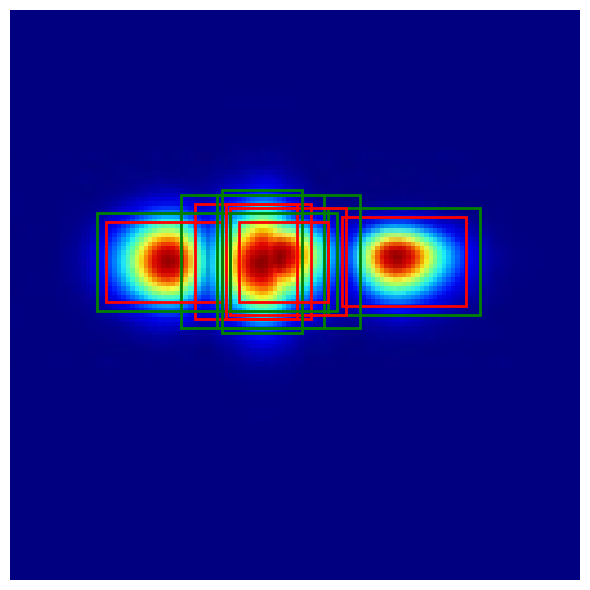

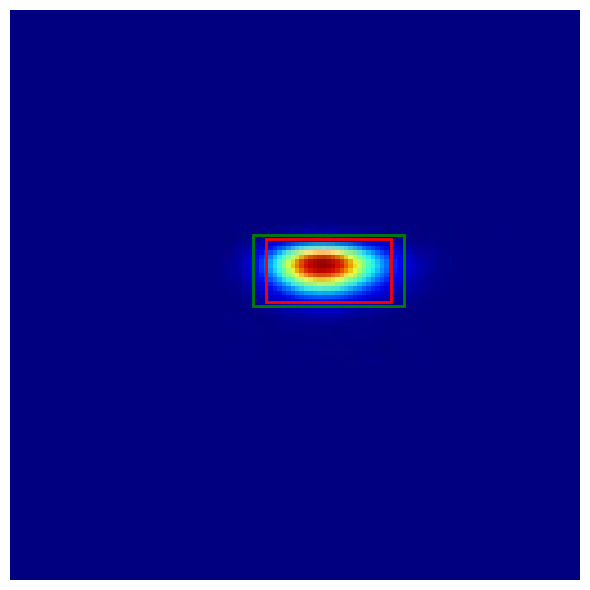

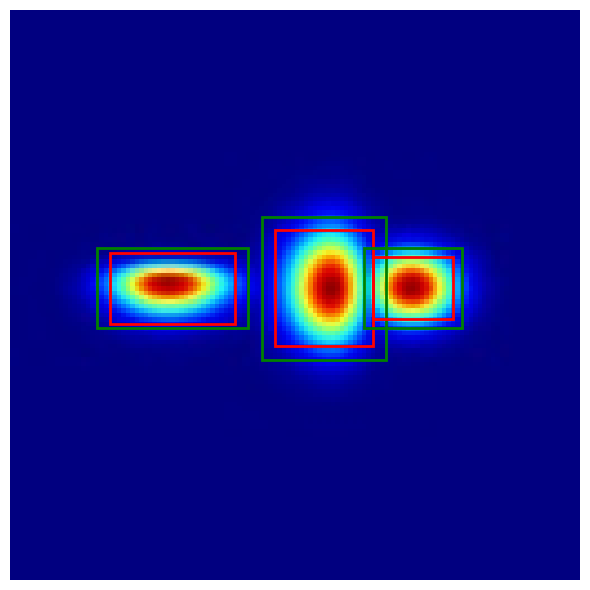

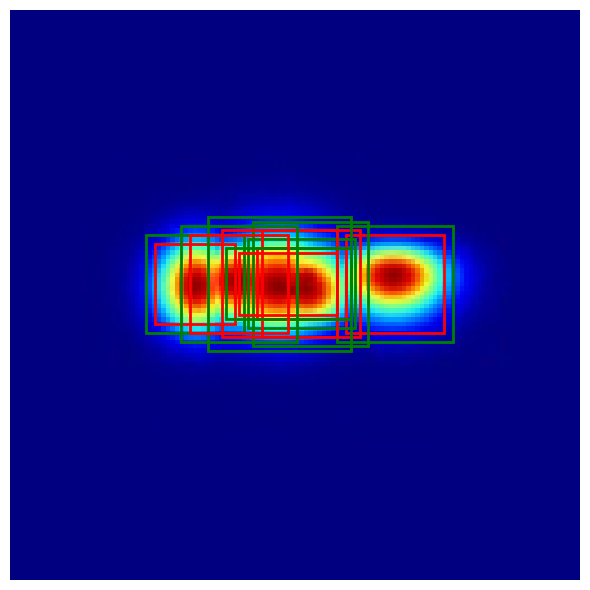

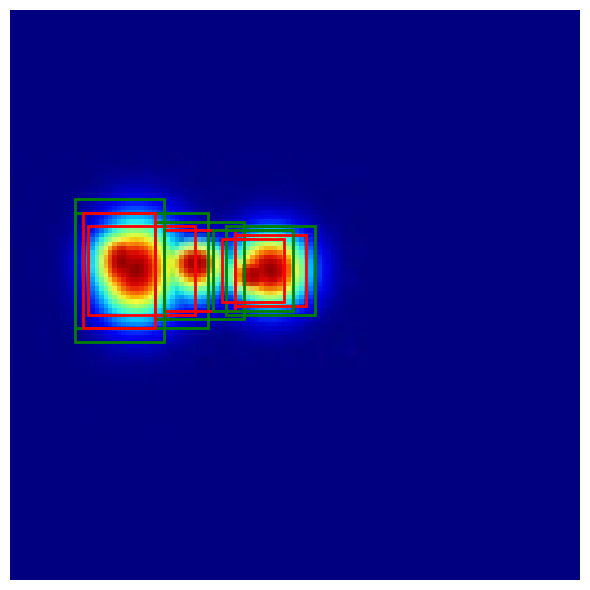

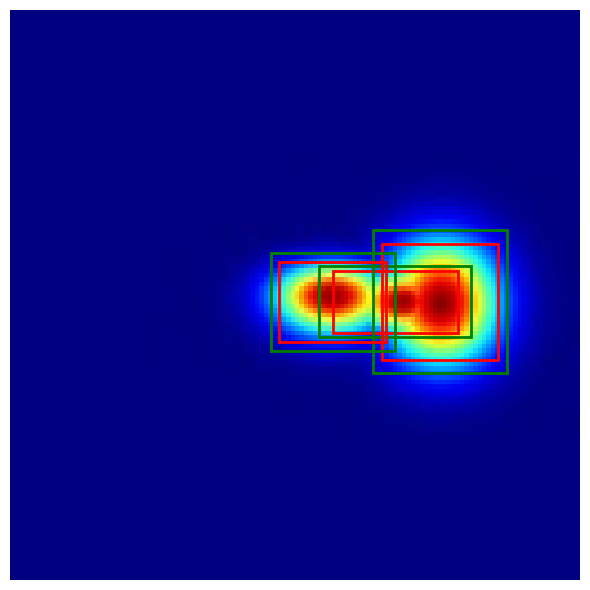

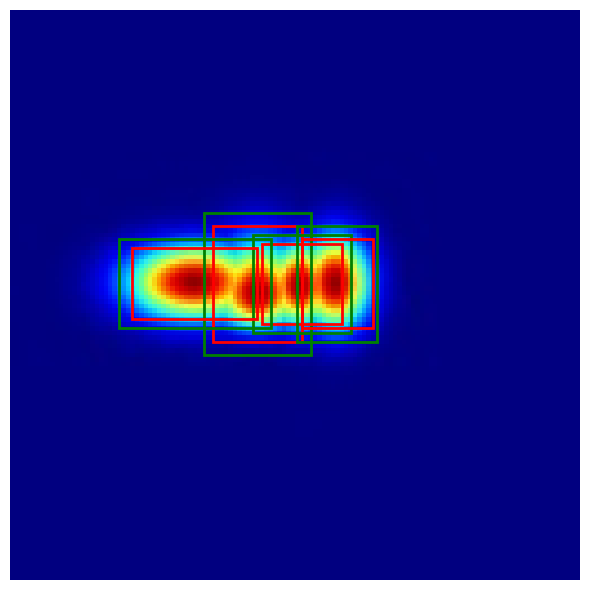

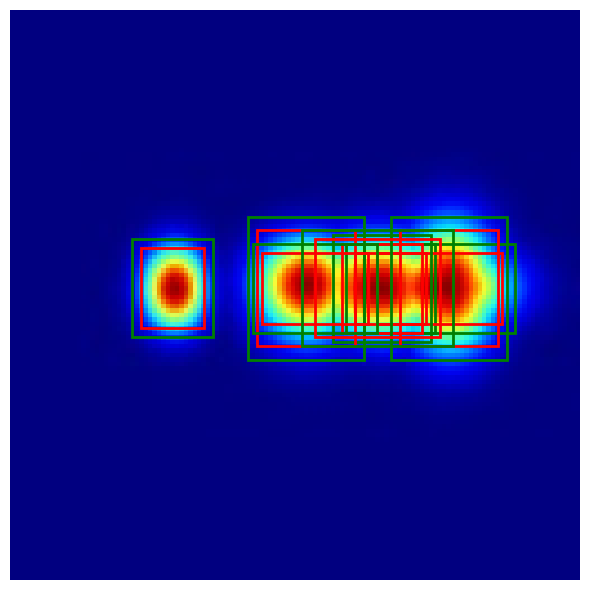

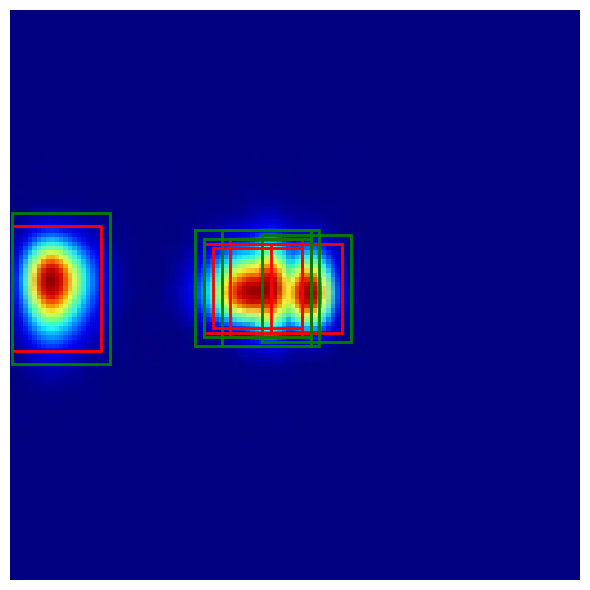

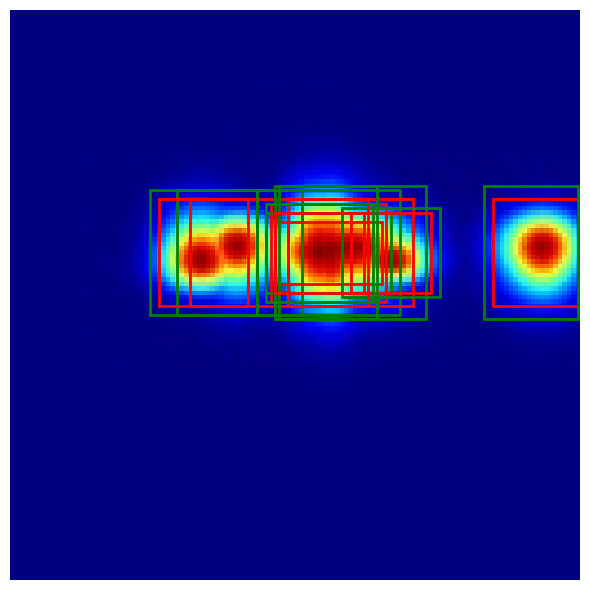

In [45]:
visualize_random_samples(os.path.join(OUTPUT_DIR,IMAGE_DIR), os.path.join(OUTPUT_DIR,LABEL_DIR), num_samples=10)


In [46]:
# import os

# def get_folder_size(path):
#     total_size = 0
#     for dirpath, dirnames, filenames in os.walk(path):
#         for f in filenames:
#             fp = os.path.join(dirpath, f)
#             if os.path.exists(fp):
#                 total_size += os.path.getsize(fp)
#     return total_size

# folder_path = os.getcwd() + "/" +BlockingIOError OUTPUT_DIR
# size_bytes = get_folder_size(folder_path)
# print(f"Folder size: {size_bytes / (1024 * 1024):.2f} MB")


In [47]:
'''
import os

# Define the target directory
directory = 'data/hm_dataset_min_max/images'

# Get full paths of all files in the directory
all_files = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

# Set batch size
batch_size = 100

# Loop through and delete files in batches
for i in range(0, len(all_files), batch_size):
    batch = all_files[i:i + batch_size]
    for file_path in batch:
        try:
            os.remove(file_path)
            print(f"Deleted: {file_path}")
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")
    print(f"✅ Batch {i // batch_size + 1} completed.")
'''

'\nimport os\n\n# Define the target directory\ndirectory = \'data/hm_dataset_min_max/images\'\n\n# Get full paths of all files in the directory\nall_files = [os.path.join(directory, f) for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]\n\n# Set batch size\nbatch_size = 100\n\n# Loop through and delete files in batches\nfor i in range(0, len(all_files), batch_size):\n    batch = all_files[i:i + batch_size]\n    for file_path in batch:\n        try:\n            os.remove(file_path)\n            print(f"Deleted: {file_path}")\n        except Exception as e:\n            print(f"Error deleting {file_path}: {e}")\n    print(f"✅ Batch {i // batch_size + 1} completed.")\n'

Chosen sigmas (σx, σy): (10.869408195643889, 9.682396919880048)


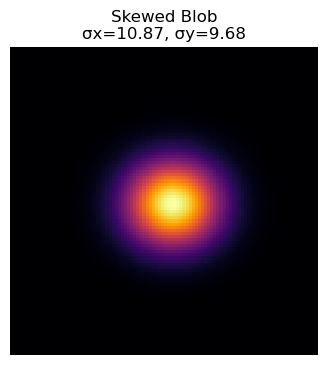

In [239]:
import numpy as np
import random
from scipy.stats import skewnorm

def generate_skewed_blob(image_size,
                         center,
                         sigma_x_range,
                         sigma_y_range,
                         alpha_x_range,
                         alpha_y_range):
    """
    Create a fully asymmetric (skewed) Gaussian-like blob and
    return it along with the selected sigmas.

    :param image_size: Tuple[int, int] (height, width) of the output image
    :param center: Tuple[int, int] (x, y) pixel coordinates of the blob center
    :param sigma_x_range: Tuple[float, float] range from which to pick σx
    :param sigma_y_range: Tuple[float, float] range from which to pick σy
    :param alpha_x_range: Tuple[float, float] range from which to pick αx (skew on x)
    :param alpha_y_range: Tuple[float, float] range from which to pick αy (skew on y)
    :return:
        blob: np.ndarray of shape (height, width), values in [0,1]
        sigma: Tuple[float, float] = (σx, σy)
    """
    h, w = image_size
    cx, cy = center

    # pick random scales and skews
    sigma_x = random.uniform(*sigma_x_range)
    sigma_y = random.uniform(*sigma_y_range)
    alpha_x = random.uniform(*alpha_x_range)
    alpha_y = random.uniform(*alpha_y_range)

    # build coordinate grid relative to center
    xs = np.arange(w) - cx
    ys = np.arange(h) - cy
    xv, yv = np.meshgrid(xs, ys)

    # normalize by chosen sigmas
    nx = xv / sigma_x
    ny = yv / sigma_y

    # skew-normal marginals
    fx = skewnorm.pdf(nx, a=alpha_x)
    fy = skewnorm.pdf(ny, a=alpha_y)

    # joint asymmetric blob
    blob = fx * fy

    # normalize to [0,1]
    if blob.max() > 0:
        blob /= blob.max()

    # return in the same style as the original function
    sigma = (sigma_x, sigma_y)
    return blob, sigma


# Example usage
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    # generate one blob
    blob, sigma = generate_skewed_blob(
        image_size=(100, 100),
        center=(50, 50),
        sigma_x_range=(3.0, 12.0),
        sigma_y_range=(3.0, 12.0),
        alpha_x_range=(-1.0, 1.0),
        alpha_y_range=(-1.0, 1.0)
    )

    print("Chosen sigmas (σx, σy):", sigma)

    # plot
    plt.figure(figsize=(4, 4))
    plt.imshow(blob, cmap="inferno")
    plt.title(f"Skewed Blob\nσx={sigma[0]:.2f}, σy={sigma[1]:.2f}")
    plt.axis("off")
    plt.show()
